In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas import DataFrame
import pickle
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Load and preprocess the data
df = pd.read_csv('../data/bintulu/bintulu-rainfall-daily.csv', encoding='latin')
# df = pd.read_csv('../data/lawas/lawas-rainfall-daily.csv', encoding='latin')
df["DateTime"] = pd.to_datetime(df["DateTime"],format="%Y-%m-%d")
df.set_index("DateTime",inplace=True)
# df_target = df[["Rainfall"]]
df.drop(columns=["TOTAL", "ClimAdjust", "Latitude", "Longitude", "Elevation"], inplace=True)
# df.drop(columns=["TOTAL", "ClimAdjust", "Latitude", "Longitude", "Elevation","Rainfall"], inplace=True)

In [4]:
df

,Rainfall,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir
DateTime,,,,,,,,,
2012-01-01,55.4,-0.87,81.130435,77.434783,89.043478,6.000000,4.043478,29.816522,68.236934
2012-01-02,1.2,-0.87,79.863636,76.454545,89.590909,5.772727,3.727273,29.796364,77.457652
2012-01-03,3.4,-0.87,80.333333,76.333333,88.125000,6.000000,4.083333,29.788750,38.298448
2012-01-04,4.2,-0.87,78.458333,75.833333,92.208333,6.000000,3.250000,29.810000,111.273322
2012-01-05,88.0,-0.87,78.772727,75.272727,89.590909,5.300909,3.545455,29.807273,351.877250
...,...,...,...,...,...,...,...,...,...
2021-12-27,0.8,-1.06,79.666667,74.166667,84.083333,6.000000,3.500000,29.777500,184.722626
2021-12-28,0.0,-1.06,80.583333,74.250000,82.666667,6.000000,3.166667,29.755417,111.540951
2021-12-29,0.6,-1.06,80.458333,73.666667,81.416667,5.875000,3.125000,29.743750,88.147018


In [5]:
# temporal features
df['Day_of_Week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Day_of_Year'] = df.index.dayofyear

def cyclical_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

df = cyclical_encode(df, 'Month', 12)
df = cyclical_encode(df, 'Day_of_Week', 7)
df = cyclical_encode(df, 'Day_of_Year', 366)
df.drop(['Month','Day_of_Week','Day_of_Year'], axis=1,inplace=True)

print(df.columns.to_list())
print(f"columns length after temporal features: {df.columns.size}")

['Rainfall', 'ANOM', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure', 'WindDir', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Day_of_Year_sin', 'Day_of_Year_cos']
columns length after temporal features: 15


In [6]:
# Define feature groups
interaction_features = {
    'Rainfall': ['Temperature', 'Humidity', 'Visibility', 'WindDir'],
    'Temperature': ['DewPoint', 'Humidity', 'Visibility', 'Pressure'],
    'Humidity': ['DewPoint', 'WindSpeed', 'WindDir'],
    'Visibility': ['WindSpeed', 'WindDir'],
    'WindDir': ['WindSpeed']
}

# Create interaction features
for feature, correlated_features in interaction_features.items():
    for correlated_feature in correlated_features:
        interaction_term = f'{feature}_{correlated_feature}'
        df[interaction_term] = df[feature] * df[correlated_feature]

df['Rainfall_Temperature_Humidity'] = df['Rainfall'] * df['Temperature'] * df['Humidity']
print(df.columns.to_list())
print(f"columns length after interaction: {df.columns.size}")

['Rainfall', 'ANOM', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure', 'WindDir', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Day_of_Year_sin', 'Day_of_Year_cos', 'Rainfall_Temperature', 'Rainfall_Humidity', 'Rainfall_Visibility', 'Rainfall_WindDir', 'Temperature_DewPoint', 'Temperature_Humidity', 'Temperature_Visibility', 'Temperature_Pressure', 'Humidity_DewPoint', 'Humidity_WindSpeed', 'Humidity_WindDir', 'Visibility_WindSpeed', 'Visibility_WindDir', 'WindDir_WindSpeed', 'Rainfall_Temperature_Humidity']
columns length after interaction: 30


In [7]:
df['DewPoint_Depression'] = df['Temperature'] - df['DewPoint']
df['WindDir_u'] = np.cos(np.radians(df['WindDir']))
df['WindDir_v'] = np.sin(np.radians(df['WindDir']))
df['Humidity_Pressure_Index'] = df['Humidity'] * (1/df['Pressure'])

In [8]:
print(df.columns.to_list())
print(f"columns length after interaction: {df.columns.size}")

['Rainfall', 'ANOM', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure', 'WindDir', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Day_of_Year_sin', 'Day_of_Year_cos', 'Rainfall_Temperature', 'Rainfall_Humidity', 'Rainfall_Visibility', 'Rainfall_WindDir', 'Temperature_DewPoint', 'Temperature_Humidity', 'Temperature_Visibility', 'Temperature_Pressure', 'Humidity_DewPoint', 'Humidity_WindSpeed', 'Humidity_WindDir', 'Visibility_WindSpeed', 'Visibility_WindDir', 'WindDir_WindSpeed', 'Rainfall_Temperature_Humidity', 'DewPoint_Depression', 'WindDir_u', 'WindDir_v', 'Humidity_Pressure_Index']
columns length after interaction: 34


In [9]:
for feat in ['Rainfall', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure']:
    for window in [3, 7]:
        df[f"{feat}_{window}d_avg"] = df[feat].rolling(window).mean()
        df[f"{feat}_{window}d_std"] = df[feat].rolling(window).std()
        df[f"{feat}_{window}d_sum"] = df[feat].rolling(window).sum()
        df[f"{feat}_{window}d_min"] = df[feat].rolling(window).min()
        df[f"{feat}_{window}d_max"] = df[feat].rolling(window).max()
        df[f"{feat}_{window}d_median"] = df[feat].rolling(window).median()

df.dropna(inplace=True)
print(f"columns length after rolling statistics: {df.columns.size}")

columns length after rolling statistics: 118


C:\Users\User\AppData\Local\Temp\ipykernel_26552\2256657539.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{feat}_{window}d_sum"] = df[feat].rolling(window).sum()
C:\Users\User\AppData\Local\Temp\ipykernel_26552\2256657539.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{feat}_{window}d_min"] = df[feat].rolling(window).min()
C:\Users\User\AppData\Local\Temp\ipykernel_26552\2256657539.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

In [10]:
# Define features and target
target = 'Rainfall'
features = [col for col in df.columns if col != target]

# for feature in ['Temperature', 'Humidity', 'Pressure', 'WindSpeed', 'WindDir', 'Visibility', 'DewPoint']:
for feature in features:
    # Create all lag features for the current variable
    for i in range(1, 8):
        df[f'{feature}_lag_{i}'] = df[feature].shift(i)

df.dropna(inplace=True)
print(f"columns length after lagged features: {df.columns.size}")

C:\Users\User\AppData\Local\Temp\ipykernel_26552\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{i}'] = df[feature].shift(i)
C:\Users\User\AppData\Local\Temp\ipykernel_26552\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{i}'] = df[feature].shift(i)
C:\Users\User\AppData\Local\Temp\ipykernel_26552\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

columns length after lagged features: 937


In [11]:
# Get the number of null values for each column and sort them in descending order
null_counts = df.isna().sum().sort_values(ascending=False)

# Filter only columns that have null values (count > 0)
null_counts = null_counts[null_counts > 0]

if len(null_counts) > 0:
    print("Columns with null values:")
    print(null_counts)
else:
    print("No null values found in the dataset")

No null values found in the dataset


In [12]:
# Split the data
X = df[features]
y = df[target]

# Split into train and test sets
# train_size = int(len(df) * 0.7)
# X_train = X[:train_size]
# X_test = X[train_size:]
# y_train = y[:train_size]
# y_test = y[train_size:]

# Scale the data using RobustScaler
scaler_X = RobustScaler()
scaler_y = PowerTransformer(method='yeo-johnson')
# scaler_y = RobustScaler()

X_scaled = scaler_X.fit_transform(X)

y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape input data for LSTM [samples, time steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# import h5 model
model = load_model('LSTM1_trial5.h5')
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       251,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,585 (1.33 MB)

 Trainable params: 347,585 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# # Split the data
# X = df[features]
# y = df[target]

# # Split into train and test sets
# train_size = int(len(df) * 0.7)
# X_train = X[:train_size]
# X_test = X[train_size:]
# y_train = y[:train_size]
# y_test = y[train_size:]

# # Scale the data using RobustScaler
# scaler_X = RobustScaler()
# scaler_y = PowerTransformer(method='yeo-johnson')
# # scaler_y = RobustScaler()

# X_train_scaled = scaler_X.fit_transform(X_train)
# X_test_scaled = scaler_X.transform(X_test)

# y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
# y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# # Reshape input data for LSTM [samples, time steps, features]
# X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
# X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# # import h5 model
# model = load_model('LSTM1_trial5.h5')
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
# model.summary()

114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
MAE (Test): 2.4057
MSE (Test): 39.1310
RMSE (Test): 6.2555
R2 (Test): 0.9209
MAPE (Test): 30.4740%


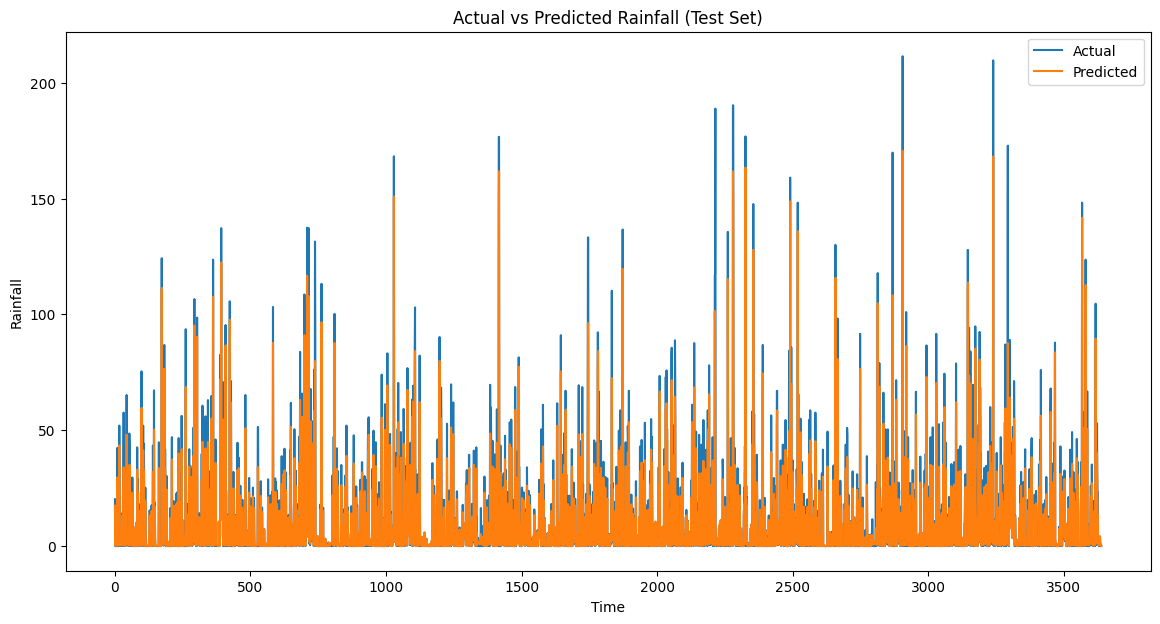

In [14]:
# Predict on the training set
y_pred_scaled = model.predict(X_reshaped)

# Inverse transform the scaled predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_scaled)

# get the sample data into a dataframe
df_results = pd.DataFrame(y_actual, columns=['actual'])
df_results['predicted'] = y_pred

# Calculate evaluation metrics
mae_test = mean_absolute_error(y_actual, y_pred)
mse_test = mean_squared_error(y_actual, y_pred)
rmse_test = np.sqrt(mse_test) 
r2_test = r2_score(y_actual, y_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Handle zero values in y_true to avoid division by zero
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape_test = mean_absolute_percentage_error(y_actual, y_pred)

print(f'MAE (Test): {mae_test:.4f}')
print(f'MSE (Test): {mse_test:.4f}')
print(f'RMSE (Test): {rmse_test:.4f}')
print(f'R2 (Test): {r2_test:.4f}')
print(f'MAPE (Test): {mape_test:.4f}%')

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Rainfall (Test Set)')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

In [15]:
print(df_results.describe())
print(df.shape)

            actual    predicted
count  3640.000000  3640.000000
mean     11.517967     9.442630
std      22.251964    17.725183
min       0.000000    -0.058827
25%       0.000000     0.263665
50%       1.600000     1.809523
75%      13.400000    12.064805
max     211.400000   170.562561
(3640, 937)
